# Boosted Decision Tree

### Looking at the csv files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

import csv

with open('.//data//300.csv') as signalfile:
    readCSV = csv.reader(signalfile)
    variable = next(readCSV)

    row_numbers = []
    
    for thing in readCSV:
        row_number = thing[0]
        row_numbers.append(row_number)
        
    print("The number of data points is:", len(row_numbers))
    print("These are the variables:", variable[1:])

C:\Users\bmand\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


The number of data points is: 64754
These are the variables: ['weight', 'mBBres', 'METHT', 'mVHres', 'nTags', 'mLL', 'ptL1', 'ptL2', 'pTB1', 'pTB2', 'ptH', 'pTV', 'dEtaBB', 'dEtaLL', 'dPhiBB', 'dPhiLL', 'MV2c10B1', 'MV2c10B2', 'MCChannelNumber']


In [2]:
with open('.//data//background.csv') as bkgfile:
    readCSV = csv.reader(bkgfile)
    variable = next(readCSV)

    row_numbers = []
    
    for thing in readCSV:
        row_number = thing[0]
        row_numbers.append(row_number)
        
    print("The number of data points is:", len(row_numbers))
    print("These are the variables:", variable[1:])

The number of data points is: 622950
These are the variables: ['weight', 'mBBres', 'METHT', 'mVHres', 'nTags', 'mLL', 'ptL1', 'ptL2', 'pTB1', 'pTB2', 'ptH', 'pTV', 'dEtaBB', 'dEtaLL', 'dPhiBB', 'dPhiLL', 'MV2c10B1', 'MV2c10B2', 'MCChannelNumber']


### Now using pandas:

#### Opening the files using pandas
I also dropped variables we don't want to included

In [3]:
import pandas as pd

signal = pd.read_csv('.//data//300.csv', index_col=0)
background = pd.read_csv('.//data//background.csv', index_col=0)

signal.drop(["nTags", "MCChannelNumber", "mVHres"], axis=1, inplace=True)
background.drop(["nTags", "MCChannelNumber", "mVHres"], axis=1, inplace=True)

#### Setting up the train and test data
I also dropped the variable weight
Here I used code from https://github.com/qiutt1994/AZhanalysis/blob/master/mlstudent3/training.py 

In [4]:
train_bkg, test_bkg = train_test_split(background, test_size=0.4, random_state=2)
train_signal, test_signal = train_test_split(signal, test_size=0.4, random_state=2)

train_y = len(train_bkg) * [0] + len(train_signal) * [1]
test_y = len(test_bkg) * [0] + len(test_signal) * [1]

train_x = pd.concat([train_bkg, train_signal], ignore_index=True)
test_x = pd.concat([test_bkg, test_signal], ignore_index=True)

train_x.drop(["weight"], axis=1, inplace=True)
test_x.drop(["weight"], axis=1, inplace=True)

print("Data has been split into test and train samples")
print("\tN(train) = ", len(train_x))
print("\tN(test)  = ", len(test_x))


Data has been split into test and train samples
	N(train) =  412622
	N(test)  =  275082


In [5]:
print("\033[1mFit the decision tree\033[0m")
BDT_clf = AdaBoostClassifier(n_estimators=100).fit(train_x, train_y)

print("... now compute the decision tree score")
train_score = BDT_clf.score(train_x, train_y)
test_score  = BDT_clf.score(test_x, test_y)

print("\nDecision Tree Classifier Score is:")
print("\tTrain Score = ", train_score, " (This measure of performance is biased)")
print("\tTest Score  = {:5.4f}".format(test_score))
print("\tNumber of mis-classified test data = {:2.1f}".format((1-test_score)*len(test_x)))

Fit the decision tree
... now compute the decision tree score

Decision Tree Classifier Score is:
	Train Score =  0.9059502401713917  (This measure of performance is biased)
	Test Score  = 0.9060
	Number of mis-classified test data = 25866.0


## Evaluating the model


Study the test data

confusion matrix (test) = 
 [[249072    108]
 [ 25758    144]]


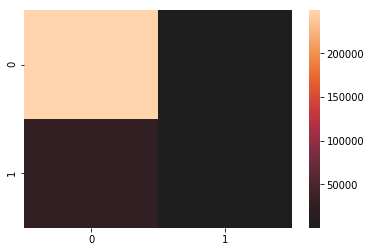


Check ground truth against predictions for the test sample
Truth	Prediction	Correct Prediction

Run Cross Validation On the Sample
cross validation scores =  [0.90596789 0.9059073  0.90617275 0.90584557 0.90589404]
	mean = 0.9060


In [6]:
#
# Use the test data to compute a confusion matrix and to compare predictions against
# the ground truth labels.
#
print("\n\033[1mStudy the test data\033[0m")
predictions = BDT_clf.predict(test_x)
BDTcm = confusion_matrix(test_y, predictions)
print("\nconfusion matrix (test) = \n", BDTcm)
sns.heatmap(BDTcm, center=True)
plt.show()

#
# Compare the ground truth and model prediction
#

print("\n\033[1mCheck ground truth against predictions for the test sample\033[0m")
print("Truth\tPrediction\tCorrect Prediction")
for i in range(len(predictions)):
    Match = False
    if predictions[i] == test_y[i]:
        Match = True
   # print("{:}\t{:}\t{:}".format(test_y[i], predictions[i], Match))

#
# Try cross validation with this sample - 5 splits of the data.  For this 
# look at the accuracy scores for each split in order to determine the
# mean performance.
#
print("\n\033[1mRun Cross Validation On the Sample\033[0m")
scores = cross_val_score(BDT_clf, train_x, train_y, cv=5)
print("cross validation scores = ", scores)
print("\tmean = {:5.4f}".format(scores.mean()))


## Trying to get a continuous plot 

### Using decision function

In [7]:
decision = BDT_clf.decision_function(test_x)
print('Output of Decision Function is:', decision)
print('Prediction for x_test from classifier is:', predictions)

Output of Decision Function is: [-0.00929474 -0.02848216 -0.01272646 ... -0.01621076 -0.03117932
 -0.01021979]
Prediction for x_test from classifier is: [0 0 0 ... 0 0 0]


<IPython.core.display.Javascript object>


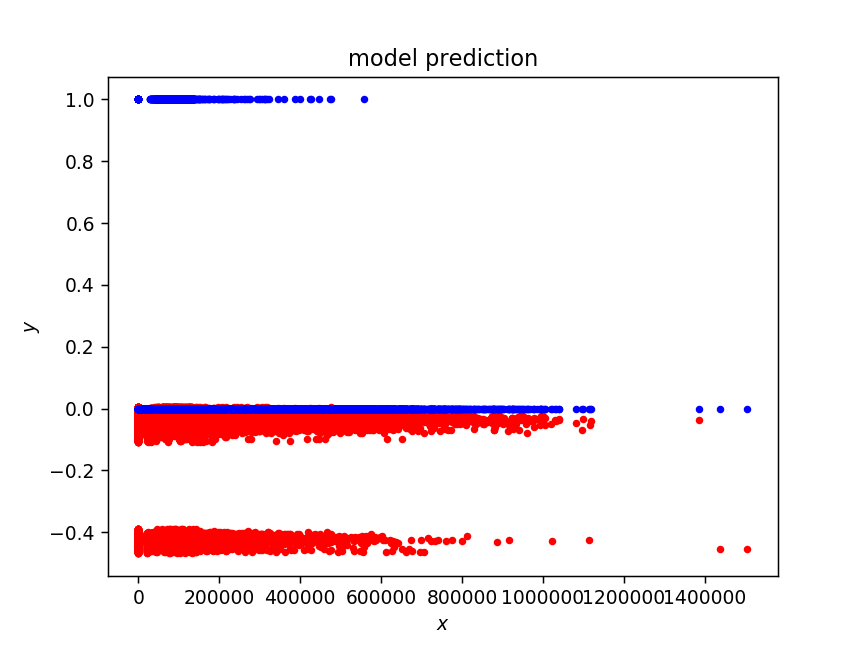

In [75]:
import matplotlib.pyplot as plt
%matplotlib notebook

y_predict = BDT_clf.decision_function(test_x)
plt.plot(test_x, y_predict, "r.")
plt.plot(test_x, predictions, "b.")
plt.title("model prediction")
plt.ylabel('$y$')
plt.xlabel('$x$')
#plt.legend(['model', 'ground truth'])
plt.show()

### Using predict proba

#### Receiver Operating Characteristic Curve (ROC)

In [23]:
probs = BDT_clf.predict_proba(test_x)
probs = probs[:, 1]

In [24]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(test_y, probs)
print('AUC: %.2f' % auc)

AUC: 0.71


<IPython.core.display.Javascript object>


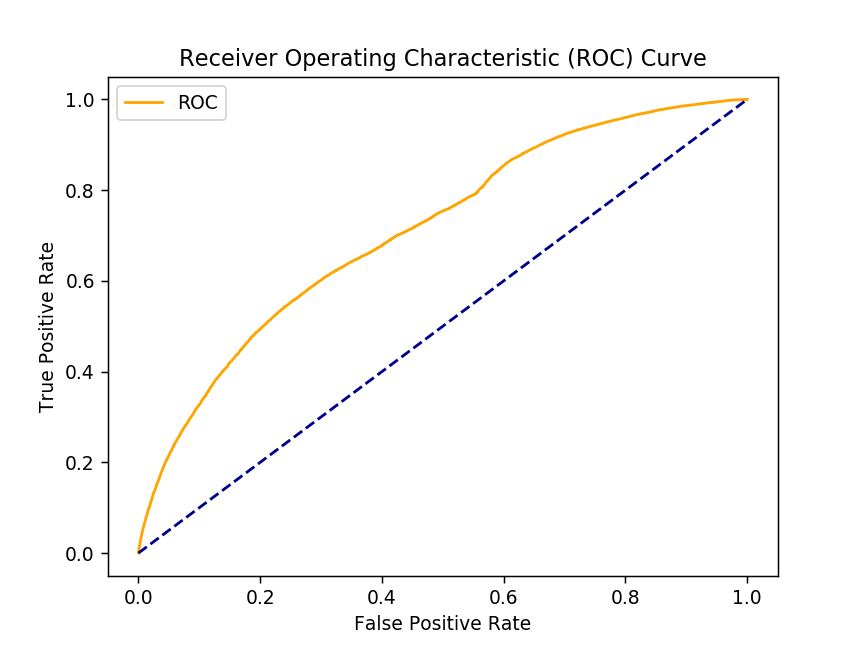

In [25]:
fpr, tpr, thresholds = roc_curve(test_y, probs)

import matplotlib.pyplot as plt
%matplotlib notebook

plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

### Trying this for max depth = 5

In [33]:
train_bkg, test_bkg = train_test_split(background, test_size=0.4, random_state=2)
train_signal, test_signal = train_test_split(signal, test_size=0.4, random_state=2)

train_y = len(train_bkg) * [0] + len(train_signal) * [1]
test_y = len(test_bkg) * [0] + len(test_signal) * [1]

train_x = pd.concat([train_bkg, train_signal], ignore_index=True)
test_x = pd.concat([test_bkg, test_signal], ignore_index=True)

train_x.drop(["weight"], axis=1, inplace=True)
test_x.drop(["weight"], axis=1, inplace=True)

print("Data has been split into test and train samples")
print("\tN(train) = ", len(train_x))
print("\tN(test)  = ", len(test_x))

Data has been split into test and train samples
	N(train) =  412622
	N(test)  =  275082


In [34]:
from sklearn.tree import DecisionTreeClassifier

print("\033[1mFit the decision tree\033[0m")
BDT_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5), algorithm="SAMME", n_estimators=100).fit(train_x, train_y)

print("... now compute the decision tree score")
train_score = BDT_clf.score(train_x, train_y)
test_score  = BDT_clf.score(test_x, test_y)

print("\nDecision Tree Classifier Score is:")
print("\tTrain Score = ", train_score, " (This measure of performance is biased)")
print("\tTest Score  = {:5.4f}".format(test_score))
print("\tNumber of mis-classified test data = {:2.1f}".format((1-test_score)*len(test_x)))

Fit the decision tree
... now compute the decision tree score

Decision Tree Classifier Score is:
	Train Score =  0.9060762635050966  (This measure of performance is biased)
	Test Score  = 0.9056
	Number of mis-classified test data = 25968.0


AUC: 0.77


<IPython.core.display.Javascript object>


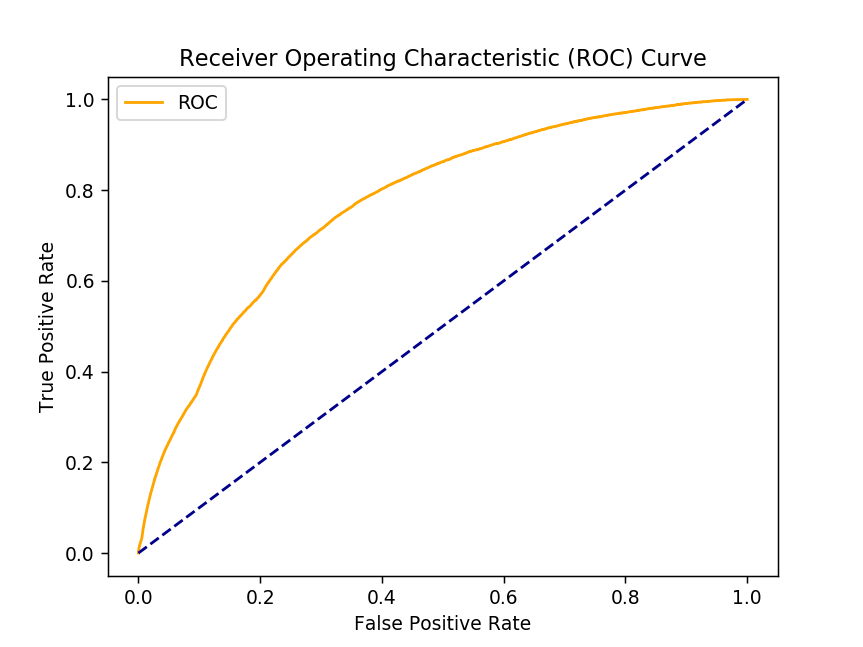

In [35]:
probs = BDT_clf.predict_proba(test_x)
probs = probs[:, 1]

auc = roc_auc_score(test_y, probs)
print('AUC: %.2f' % auc)

fpr, tpr, thresholds = roc_curve(test_y, probs)

%matplotlib notebook

plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


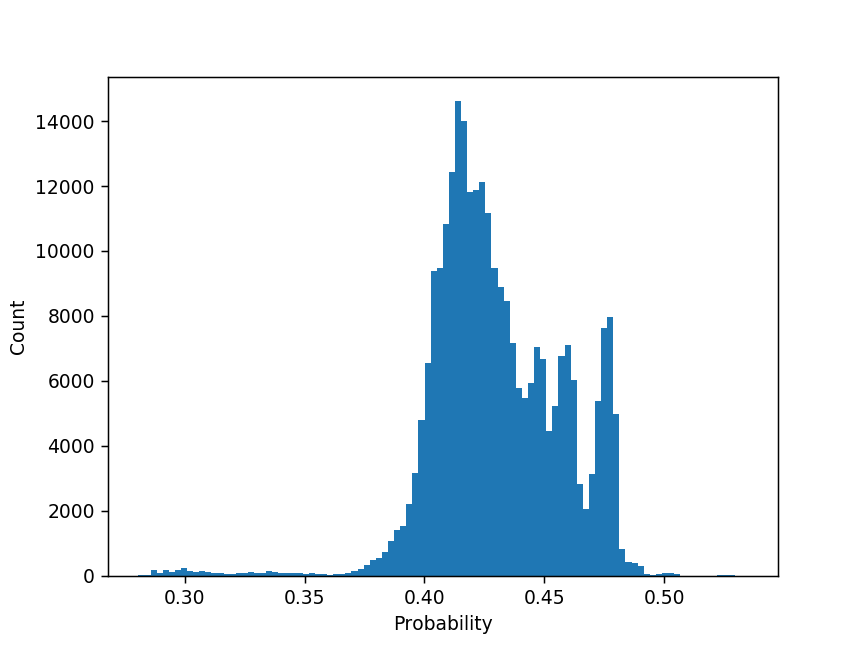

In [39]:
%matplotlib notebook
plt.hist(probs, bins=100)
plt.xlabel('Probability')
plt.ylabel('Count')
plt.show()

#### Precision Recall Curve (PRC)

In [27]:
from sklearn.metrics import precision_recall_curve

lr_precision, lr_recall, _ = precision_recall_curve(test_y, probs)
auc = roc_auc_score(test_y, probs)
print('AUC: %.2f' % auc)

AUC: 0.71


<IPython.core.display.Javascript object>


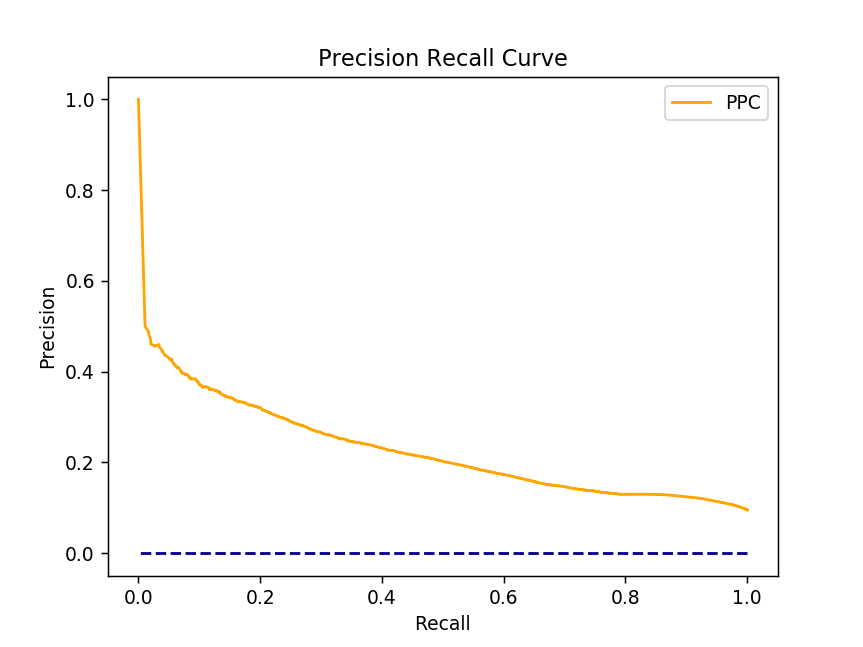

In [32]:
import matplotlib.pyplot as plt
%matplotlib notebook

plt.plot(lr_recall, lr_precision, color='orange', label='PPC')
plt.plot([1, 0], [0, 0], color='darkblue', linestyle='--')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.legend()
plt.show()